## Armed robberies in Boston over time
This project looks at monthly Boston armed robberies from Jan 1966-Oct 1975.

[Data](https://datamarket.com/data/set/22ob/monthly-boston-armed-robberies-jan1966-oct1975-deutsch-and-alt-1977#!ds=22ob&display=line) originally from : McCleary & Hay (1980)

In [1]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

print('Python version: %s.%s.%s' % sys.version_info[:3])
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)

Python version: 3.5.2
numpy version: 1.11.1
pandas version: 0.18.1


In [ ]:
def check_stationarity(timeseries):
    
    # Determine rolling statistics (moving averages and variance)
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### The data

In [2]:
data = pd.read_csv('monthly-boston-armed-robberies-j.csv',parse_dates=True, index_col='Month')
data.head()

,Monthly Boston armed robberies
Month,
1966-01-01,41
1966-02-01,39
1966-03-01,50
1966-04-01,40
1966-05-01,43


In [3]:
data.dtypes

Monthly Boston armed robberies    int64
dtype: object

In [4]:
# To confirm that dtype=datetime, or that it is a datetime object
data.index

DatetimeIndex(['1966-01-01', '1966-02-01', '1966-03-01', '1966-04-01',
               '1966-05-01', '1966-06-01', '1966-07-01', '1966-08-01',
               '1966-09-01', '1966-10-01',
               ...
               '1975-01-01', '1975-02-01', '1975-03-01', '1975-04-01',
               '1975-05-01', '1975-06-01', '1975-07-01', '1975-08-01',
               '1975-09-01', '1975-10-01'],
              dtype='datetime64[ns]', name='Month', length=118, freq=None)

In [5]:
# Converting to a series object for convenience
ts = data['Monthly Boston armed robberies'] 
ts.head()

Month
1966-01-01    41
1966-02-01    39
1966-03-01    50
1966-04-01    40
1966-05-01    43
Name: Monthly Boston armed robberies, dtype: int64

### Check stationarity

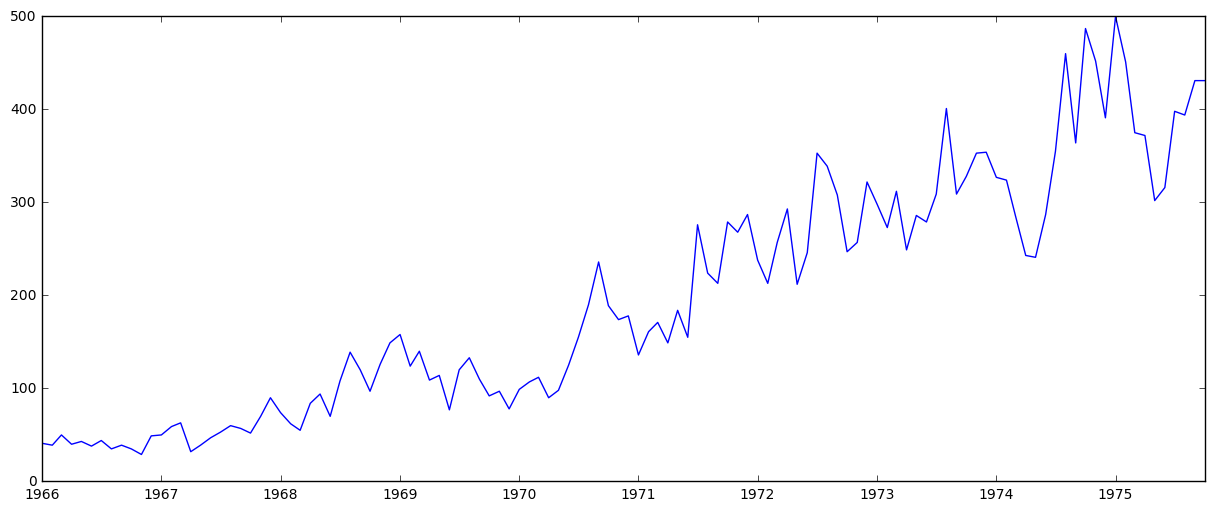

In [6]:
plt.plot(ts)

It's clear that there's an overall increasing trend, and the time series is clearly not stationary, but let's look at the moving averages/variance and implement the Dickey-Fuller test for stationarity:

/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()


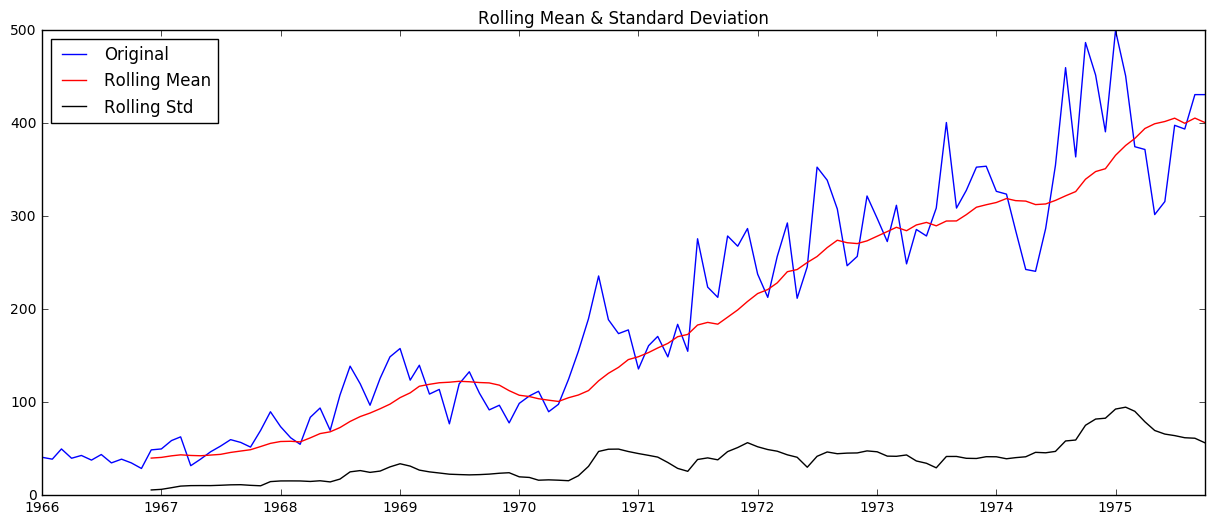

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (10%)            -2.581533
Critical Value (5%)             -2.889217
dtype: float64


In [10]:
check_stationarity(ts)

The mean (in red) is clearly increasing with time and the test statistic is much larger than the critical values, so we can't reject the null hypothesis- aka this is not a stationary series.

### Make the series stationary
#### Eliminating trend

In this case there is a significant positive trend. Let's first work on estimating and eliminating it. We can do a simple log transform (which would penalize higher values more than smaller ones).

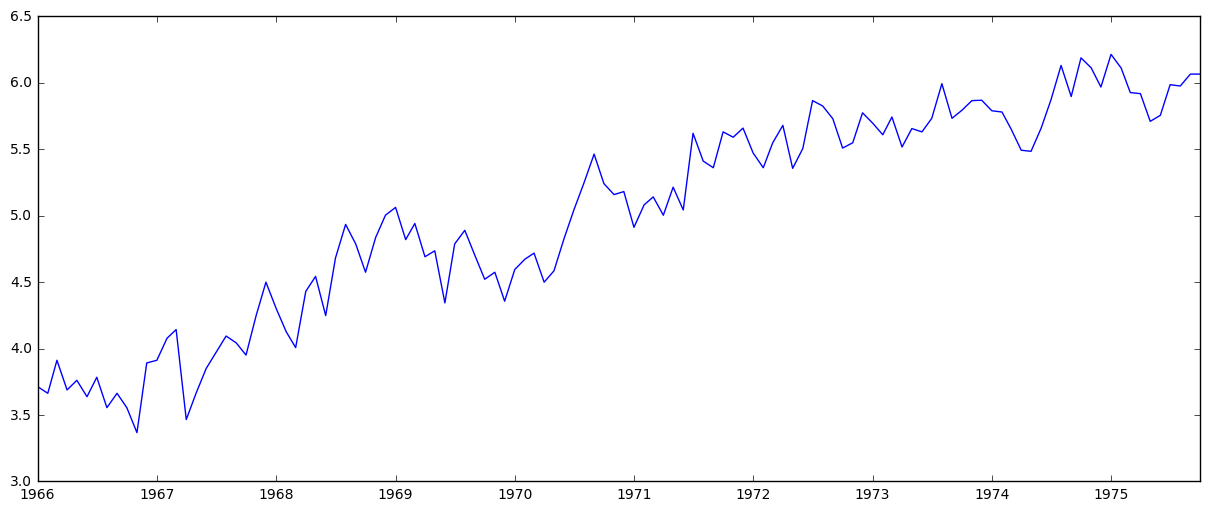

In [11]:
ts_log = np.log(ts)
plt.plot(ts_log)

As well as smoothing by taking rolling averages:

/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
  if __name__ == '__main__':


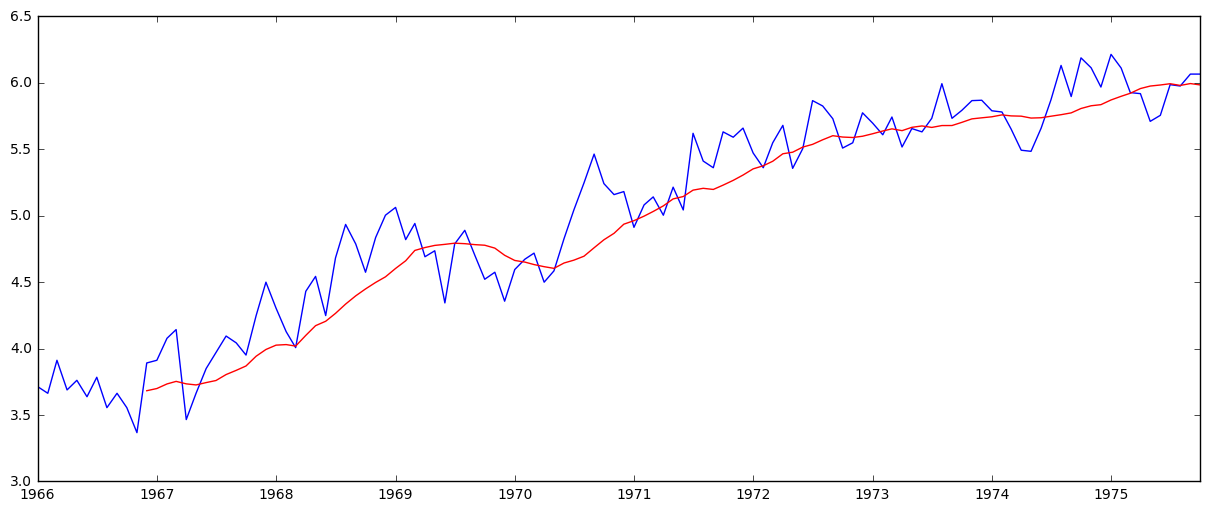

In [12]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red shows the rolling average.
Now subtract it from the original series.

Note: since we are taking the mean of the last 12 values, rolling mean is not defined for the first 11 values:

In [13]:
# Subtract rolling average
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1966-01-01         NaN
1966-02-01         NaN
1966-03-01         NaN
1966-04-01         NaN
1966-05-01         NaN
1966-06-01         NaN
1966-07-01         NaN
1966-08-01         NaN
1966-09-01         NaN
1966-10-01         NaN
1966-11-01         NaN
1966-12-01    0.208955
Name: Monthly Boston armed robberies, dtype: float64

So the first 11 are Nan. Let's drop these and then check for stationarity again:

/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()


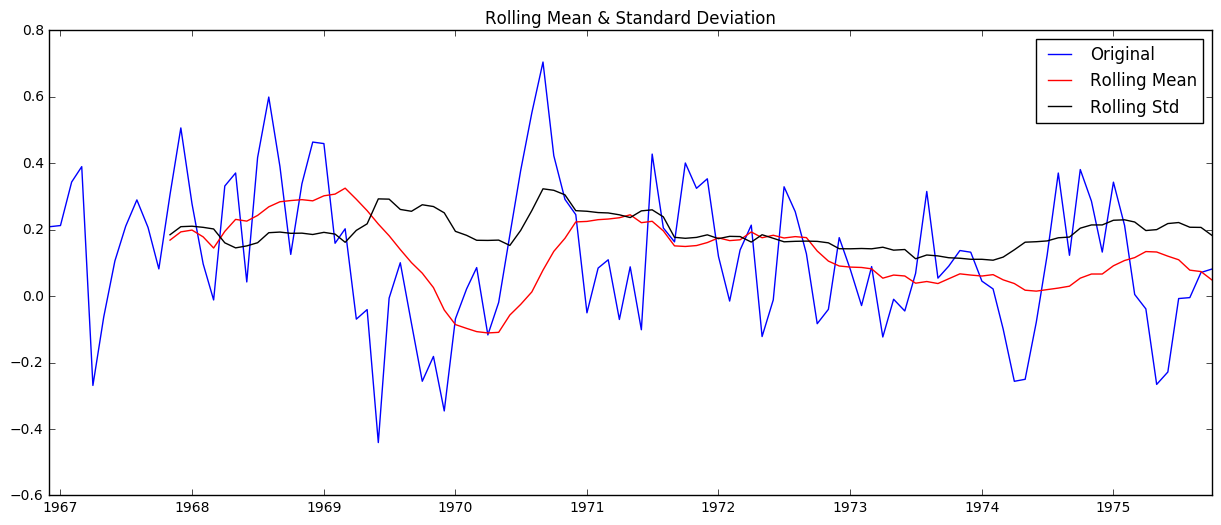

Results of Dickey-Fuller Test:
Test Statistic                  -5.323692
p-value                          0.000005
#Lags Used                       0.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (10%)            -2.581533
Critical Value (5%)             -2.889217
dtype: float64


In [14]:
ts_log_moving_avg_diff.dropna(inplace=True)
check_stationarity(ts_log_moving_avg_diff)

Now we get a test statistic that is smaller than the 1% critical value.

Now let's try a weighted moving average (where more recent values get higher weight)- more specifically an exponentially weighted moving average, where weights are assigned to all the previous values with a decay factor:

/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(adjust=True,ignore_na=False,halflife=12,min_periods=0).mean()
  if __name__ == '__main__':


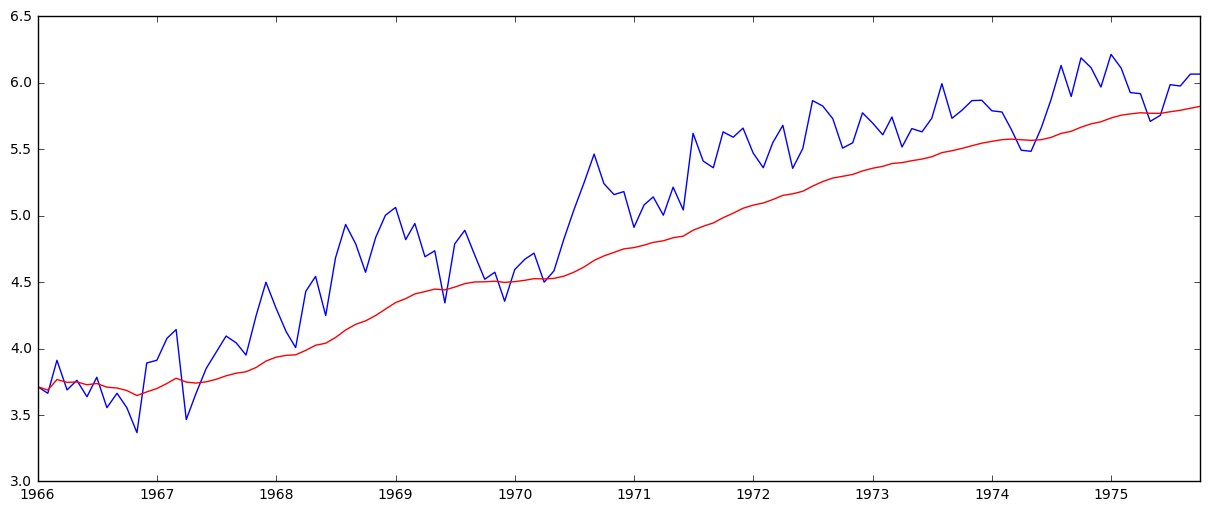

In [15]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

Now we remove this from the series and check for stationarity:

/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()


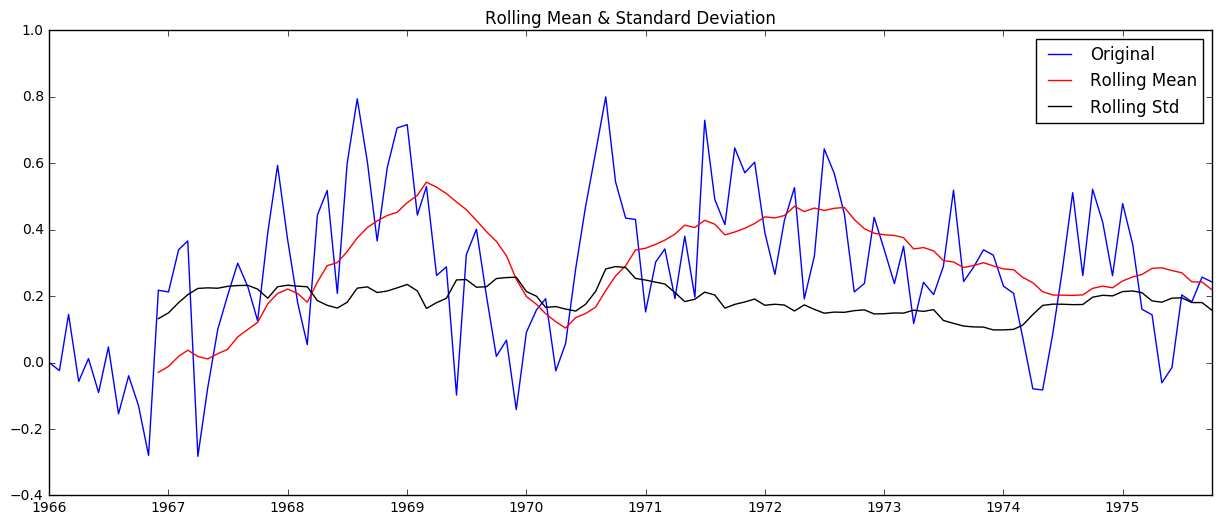

Results of Dickey-Fuller Test:
Test Statistic                  -5.155717
p-value                          0.000011
#Lags Used                       0.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (10%)            -2.580124
Critical Value (5%)             -2.886578
dtype: float64


In [16]:
ts_log_ewma_diff = ts_log - expwighted_avg
check_stationarity(ts_log_ewma_diff)

This actually isn't better than the previous method of using the simple moving average.

#### Removing trend and seasonality with differencing

Now let's try another method of removing trend, as well as seasonality: differencing.

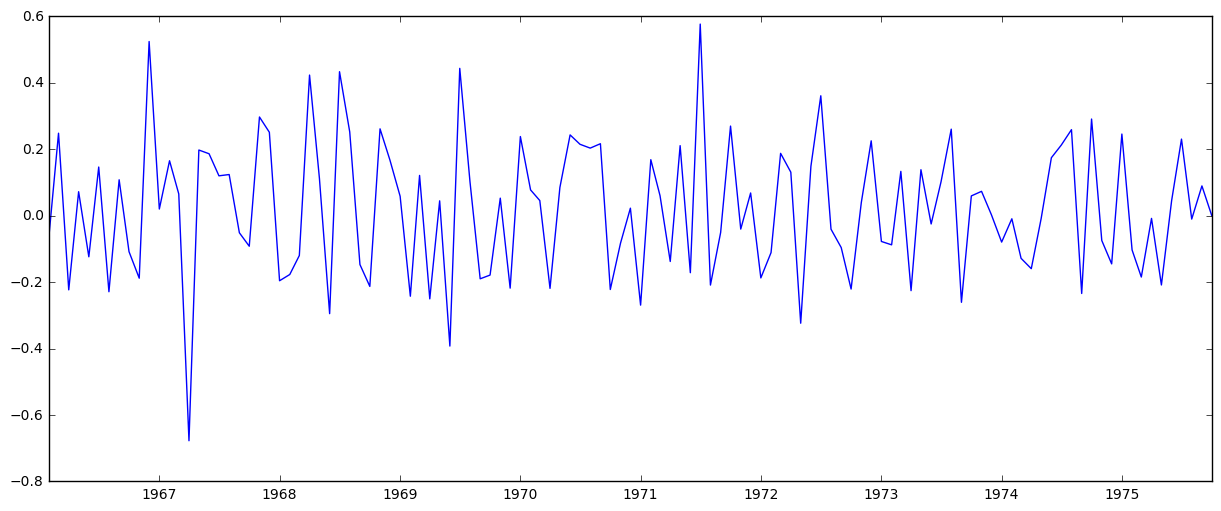

In [17]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

The trend looks like it's gone.

Check stationarity:

/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()


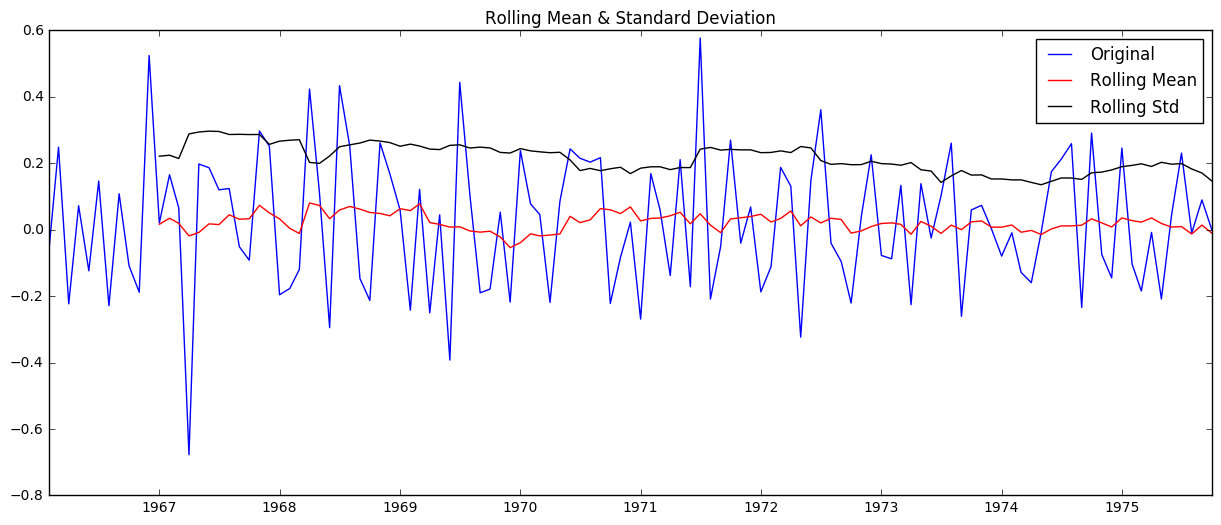

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (10%)          -2.580604e+00
Critical Value (5%)           -2.887477e+00
dtype: float64


In [18]:
ts_log_diff.dropna(inplace=True)
check_stationarity(ts_log_diff)

Again, the test statistic is significantly lower than the 1% critical value so this time series is very close to stationary.

### Forecasting

For ARIMA we need the parameters p, d, and q. Here d is the number of nonseasonal differences. We use these plots to determine p and q:

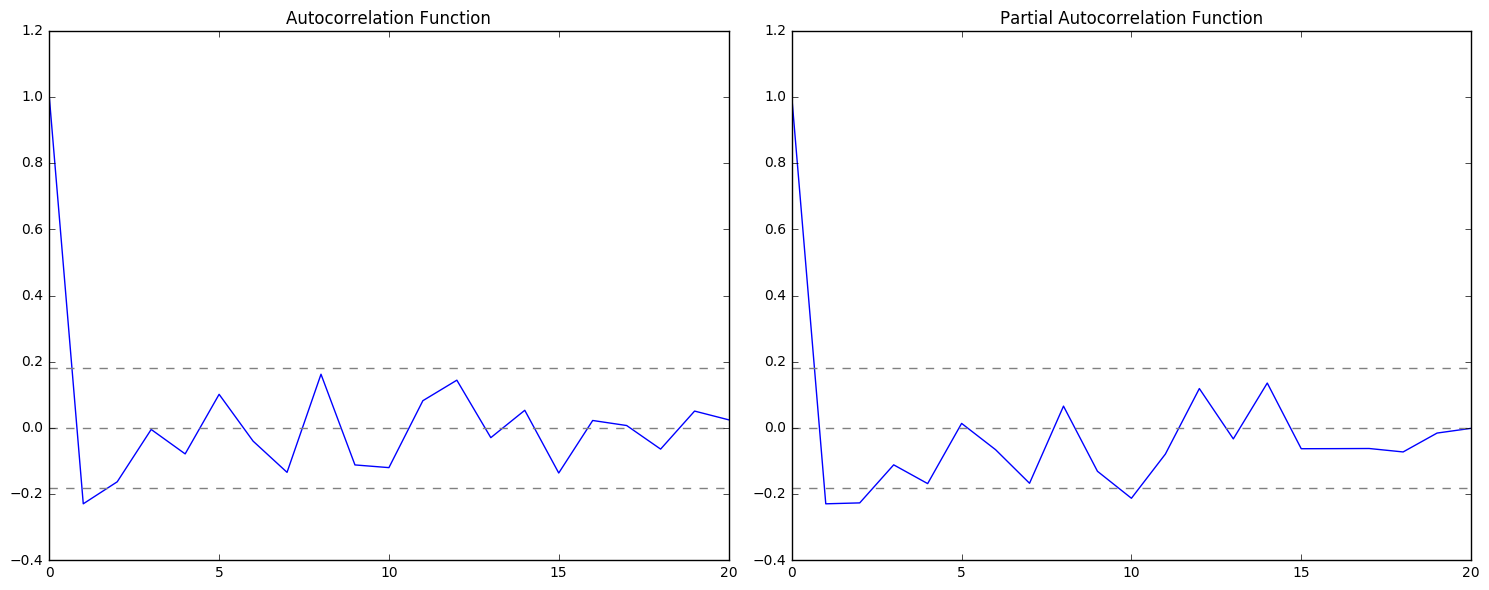

In [22]:
# ACF (autocorrelation function) and PACF (partial autocorrelation function) plots:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

# Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The two dotted lines on either sides of 0 are confidence intervals. These can be used to determine 'p' and 'q' values as (p: the lag value where the PACF chart crosses the upper confidence interval for the first time, q: the lag value where the ACF chart crosses the upper confidence interval for the first time).

In this case it looks like p=1 and q=1.

### ARIMA

I'l model 3 different ARIMA models considering individual as well as combined effects.

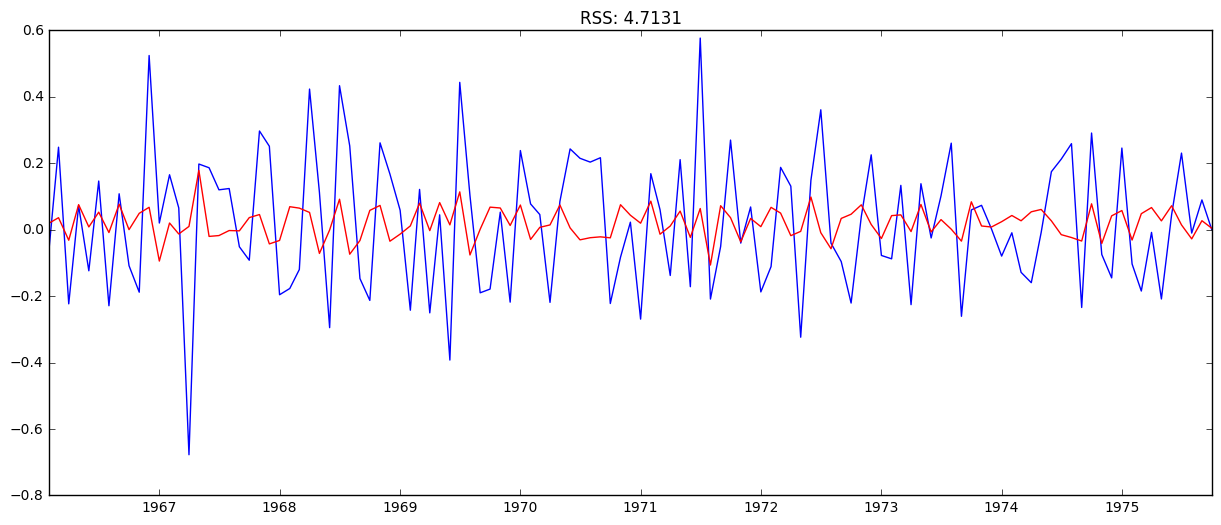

In [30]:
# AR (auto-regression) model
model = ARIMA(ts_log, order=(1, 1, 0))  # (p,d,q)
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')

# Print the RSS- values for the residuals
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

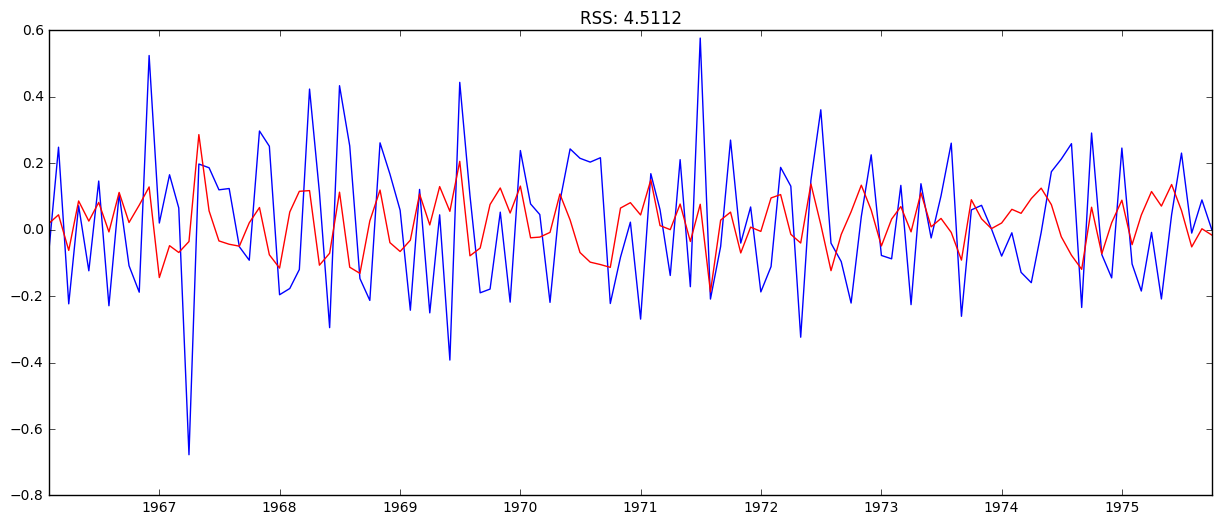

In [31]:
# MA (moving avg) model
model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

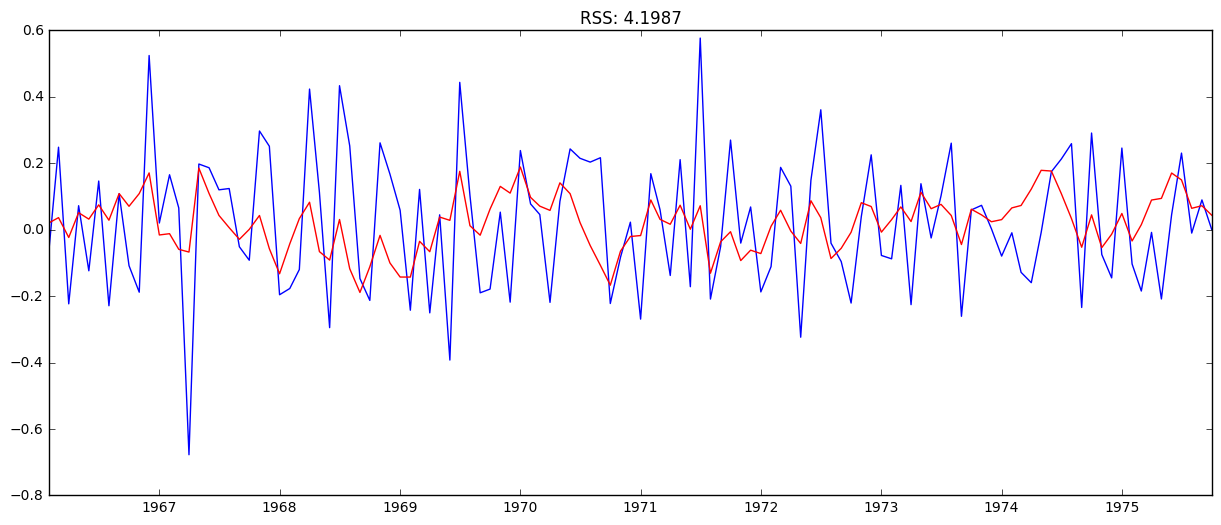

In [32]:
# Combined model
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

The combined gave the lowest RSS.

Next we take these values back to the original scale:

#### Back to the original scale

Scaling back to the original values:

In [34]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1966-02-01    0.021240
1966-03-01    0.036438
1966-04-01   -0.023285
1966-05-01    0.051275
1966-06-01    0.031915
dtype: float64


Convert differencing to log scale by adding these difference consecutively to the base number. One way to do that is to first determine the cumulative sum at index, then add it to the base number. Cumulative sum:

In [35]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1966-02-01    0.021240
1966-03-01    0.057678
1966-04-01    0.034392
1966-05-01    0.085667
1966-06-01    0.117582
dtype: float64


Next we add them to the base number, First create a series with all values as base number and add differences to it:

In [36]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1966-01-01    3.713572
1966-02-01    3.734812
1966-03-01    3.771250
1966-04-01    3.747964
1966-05-01    3.799239
dtype: float64

Then take the exponent and compare with the original series.

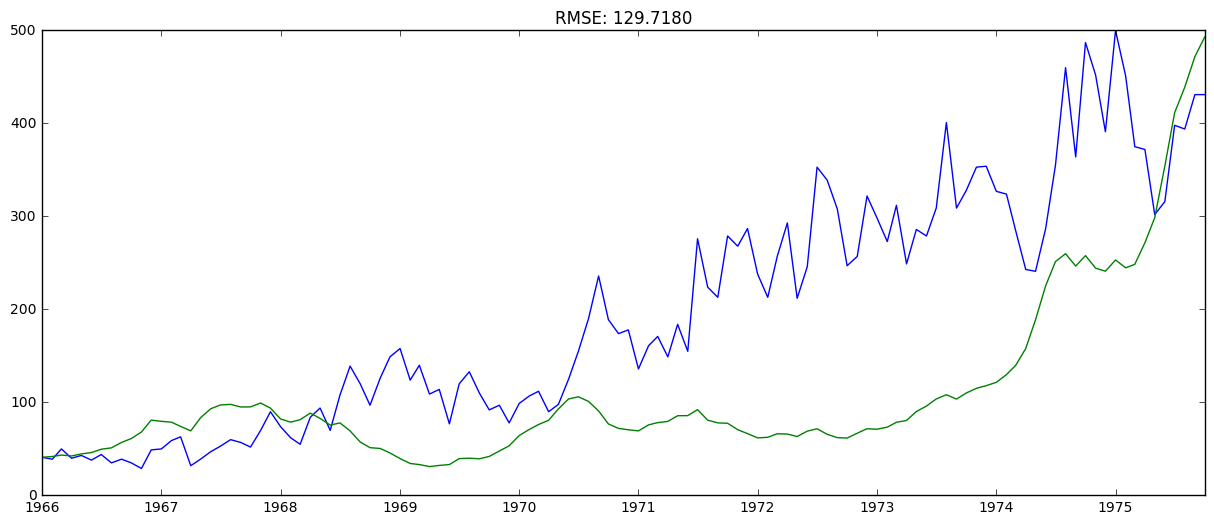

In [37]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

And that's the forecast at the original scale. It's not a great forecast. To be continued...